# Classification of penguin species

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/devmotion/CalibrationErrors.jl/blob/main/examples/classification/script.jl).
The corresponding
HTML output can be viewed [here](https://devmotion.github.io/CalibrationErrors.jl/dev/examples/classification/).*


## Packages

In [1]:
using AlgebraOfGraphics
using CairoMakie
using CalibrationErrors
using DataFrames
using Distributions
using MLJ
using MLJNaiveBayesInterface
using PalmerPenguins

using Random

# Plotting settings
set_aog_theme!()
CairoMakie.activate!(; type="svg")

## Data

In this example we study the calibration of different models that classify three penguin
species based on measurements of their bill and flipper lengths.

We use the [Palmer penguins dataset](https://allisonhorst.github.io/palmerpenguins/) to
to train and validate the models.

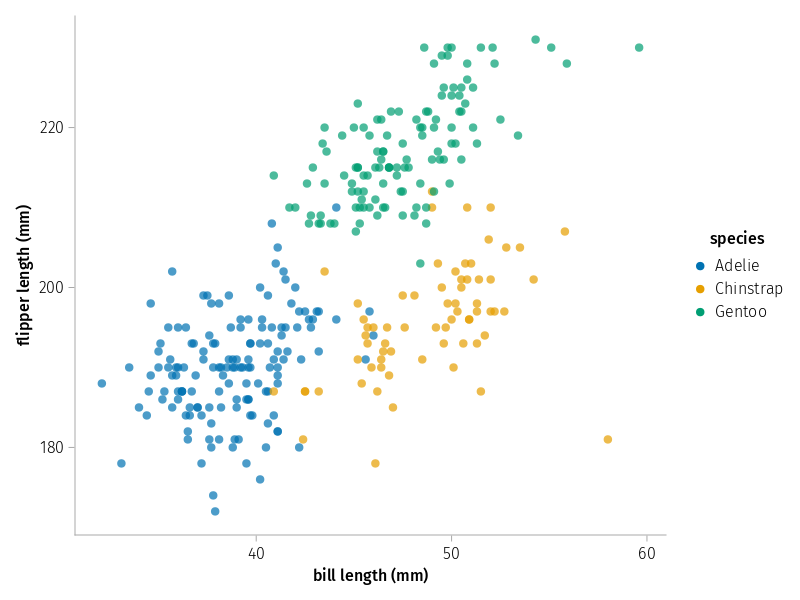

In [2]:
penguins = dropmissing(DataFrame(PalmerPenguins.load()))

penguins_mapping =
    data(penguins) * mapping(
        :bill_length_mm => "bill length (mm)", :flipper_length_mm => "flipper length (mm)"
    )
draw(penguins_mapping * mapping(; color=:species) * visual(; alpha=0.7))

We split the data randomly into a training and validation dataset. The training dataset
contains around 60% of the samples.

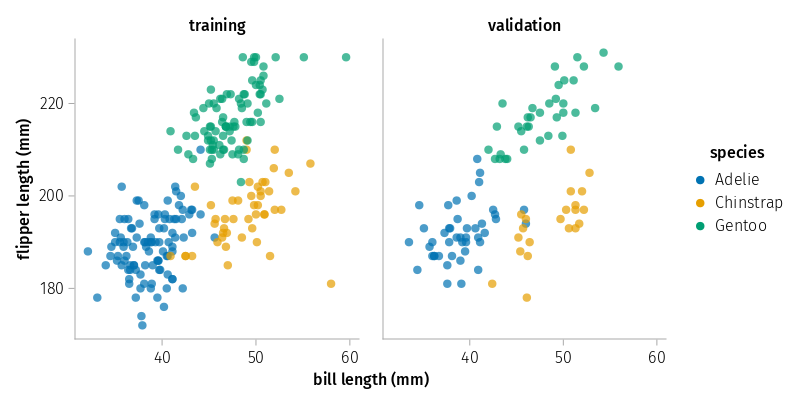

In [3]:
Random.seed!(1234)
n = nrow(penguins)
k = floor(Int, 0.7 * n)
Random.seed!(100)
penguins.train = shuffle!(vcat(trues(k), falses(n - k)))

# Plot the training and validation data
dataset = :train => renamer(true => "training", false => "validation") => "Dataset"
plt = penguins_mapping * mapping(; color=:species, col=dataset) * visual(; alpha=0.7)
draw(plt; axis=(height=300,))

## Fitting normal distributions

For each species, we fit independent normal distributions to the observations of the bill
and flipper length in the training data, using maximum likelihood estimation.

In [4]:
y, X = unpack(
    penguins,
    ==(:species),
    x -> x === :bill_length_mm || x === :flipper_length_mm;
    :species => Multiclass,
    :bill_length_mm => MLJ.Continuous,
    :flipper_length_mm => MLJ.Continuous,
)
model = fit!(machine(GaussianNBClassifier(), X, y); rows=penguins.train);

[ Info: Training machine(GaussianNBClassifier(), …).


We plot the estimated normal distributions.

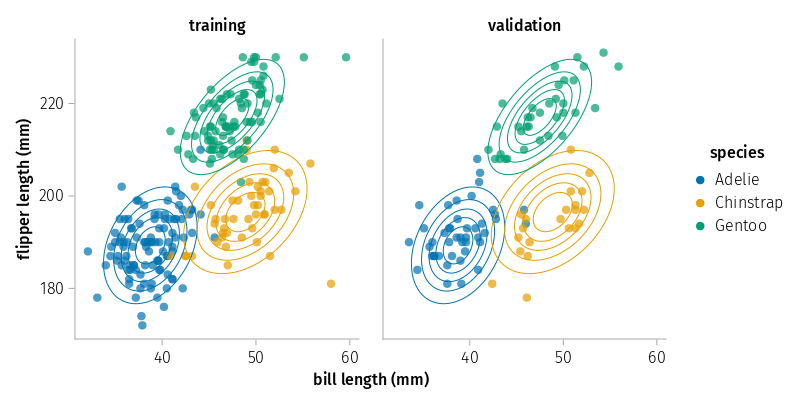

In [5]:
# plot datasets
fg = draw(plt; axis=(height=300,))

# plot Gaussian distributions
xgrid = range(extrema(penguins.bill_length_mm)...; length=100)
ygrid = range(extrema(penguins.flipper_length_mm)...; length=100)
let f = (x, y, dist) -> pdf(dist, [x, y])
    for (class, color) in zip(classes(y), Makie.wong_colors())
        pdfs = f.(xgrid, ygrid', Ref(model.fitresult.gaussians[class]))
        contour!(fg.figure[1, 1], xgrid, ygrid, pdfs; color=color)
        contour!(fg.figure[1, 2], xgrid, ygrid, pdfs; color=color)
    end
end

fg

## Naive Bayes classifier

Let us assume that the bill and flipper length are conditionally independent given the
penguin species. Then Bayes' theorem implies that
$$
\begin{aligned}
\mathbb{P}(\mathrm{species} \,|\, \mathrm{bill}, \mathrm{flipper})
&= \frac{\mathbb{P}(\mathrm{species}) \mathbb{P}(\mathrm{bill}, \mathrm{flipper} \,|\, \mathrm{species})}{\mathbb{P}(\mathrm{bill}, \mathrm{flipper})} \\
&= \frac{\mathbb{P}(\mathrm{species}) \mathbb{P}(\mathrm{bill} \,|\, \mathrm{species}) \mathbb{P}(\mathrm{flipper} \,|\, \mathrm{species})}{\mathbb{P}(\mathrm{bill}, \mathrm{flipper})}.
\end{aligned}
$$
This predictive model is known as
[naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

In the section above, we estimated $\mathbb{P}(\mathrm{species})$,
$\mathbb{P}(\mathrm{bill} \,|\, \mathrm{species})$, and
$\mathbb{P}(\mathrm{flipper} \,|\, \mathrm{species})$ for each penguin species from
the training data. For the conditional distributions we used a Gaussian approximation.

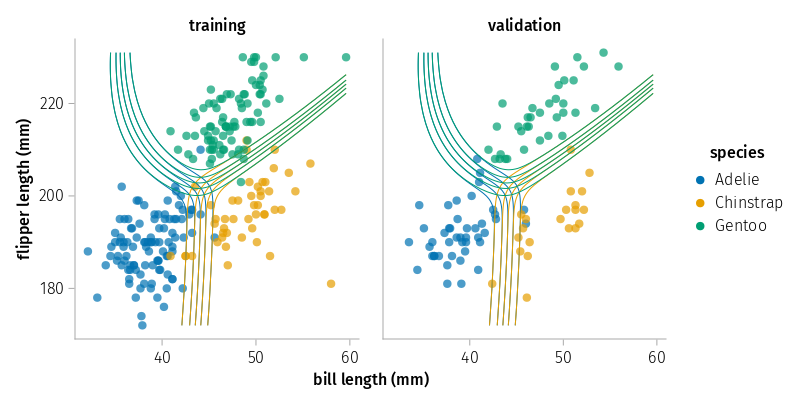

In [6]:
predictions = MLJ.predict(model)
train_predict = predictions[penguins.train]
val_predict = predictions[.!penguins.train]

# Plot datasets
fg = draw(plt; axis=(height=300,))

# Plot predictions
predictions_grid = reshape(
    MLJ.predict(model, reduce(hcat, vcat.(xgrid, ygrid'))'), length(xgrid), length(ygrid)
)
for (class, color) in zip(classes(y), Makie.wong_colors())
    p = pdf.(predictions_grid, class)
    contour!(fg.figure[1, 1], xgrid, ygrid, p; color=color)
    contour!(fg.figure[1, 2], xgrid, ygrid, p; color=color)
end

fg

## Evaluation

We evaluate the probabilistic predictions of the naive Bayes classifier that we just
trained.

### Log-likelihood

We compute the average log-likelihood of the validation data. It is equivalent to the
negative cross-entropy.

In [7]:
val_y = y[.!penguins.train]
-mean(cross_entropy(val_predict, val_y))

-0.12188703745583586

### Brier score

The average log-likelihood is also equivalent to the
[logarithmic score](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf).
The Brier score is another strictly proper scoring rule that can be used for evaluating
probabilistic predictions.

In [8]:
mean(brier_score(val_predict, val_y))

-0.07385286949971775

### Expected calibration error

As all proper scoring rules, the logarithmic and the Brier score can be [decomposed in
three terms that quantify the sharpness and calibration of the predictive model and the
irreducible uncertainty of the targets that is inherent to the prediction
problem](https://doi.org/10.1002/qj.456). The calibration term in this decomposition is
the expected calibration error (ECE)
$$
\mathbb{E} d\big(P_X, \mathrm{law}(Y \,|\, P_X)\big)
$$
with respect to the score divergence $d$.

Scoring rules, however, include also the sharpness and the uncertainty term. Thus models
can trade off calibration for sharpness and therefore scoring rules are not suitable for
specifically evaluating calibration of predictive models.

The score divergence to the logarithmic and the Brier score are the Kullback-Leibler (KL)
divergence
$$
d\big(P_X, \mathrm{law}(Y \,|\, P_X)\big) = \sum_{y} \mathbb{P}(Y = y \,|\, P_X)
\log\big(\mathbb{P}(Y = y \,|\, P_X) / P_X(\{y\})\big)
$$
and the squared Euclidean distance
$$
d\big(P_X, \mathrm{law}(Y \,|\, P_X)\big) = \sum_{y} \big(P_X - \mathrm{law}(Y \,|\, P_X)\big)^2(\{y\}),
$$
respectively. The KL divergence is defined only if $\mathrm{law}(Y \,|\, P_X)$ is
absolutely continuous with respect to $P_X$, i.e., if $P_X(\{y\}) = 0$ implies
$\mathbb{P}(Y = y \,|\, P_X) = 0$.

We estimate the ECE by binning the probability simplex of predictions $P_X$ and computing
the weighted average of the distances between the mean prediction and the distribution of
targets in each bin.

One approach is to use bins of uniform size.

In [9]:
ece = ECE(UniformBinning(10), (μ, y) -> kl_divergence(y, μ));

We have to work with a numerical encoding of the true penguin species and a
corresponding vector of predictions. We use [`RowVecs`](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/api/#KernelFunctions.RowVecs)
to indicate that the rows in the matrix of probabilities returned by `pdf`
are the predictions. If we would provide predictions as columns of a matrix, we would have
to use [`ColVecs`](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/api/#KernelFunctions.ColVecs).

In [10]:
val_yint = map(MLJ.levelcode, val_y)
val_probs = RowVecs(pdf(val_predict, MLJ.classes(y)));

We compute the estimate on the validation data:

In [11]:
ece(val_probs, val_yint)

0.04860861700674836

For the squared Euclidean distance we obtain:

In [12]:
ece = ECE(UniformBinning(10), SqEuclidean())
ece(val_probs, val_yint)

0.02426469201343113

Alternatively, one can use a data-dependent binning scheme that tries to split the
predictions in a way that minimizes the variance in each bin.

With the KL divergence we get:

In [13]:
ece = ECE(MedianVarianceBinning(5), (μ, y) -> kl_divergence(y, μ))
ece(val_probs, val_yint)

0.027874966150111966

For the squared Euclidean distance we obtain:

In [14]:
ece = ECE(MedianVarianceBinning(5), SqEuclidean())
ece(val_probs, val_yint)

0.012238423729555838

We see that the estimates (of the same theoretical quantity!) are highly dependent on the
chosen binning scheme.

### Kernel calibration error

As an alternative to the ECE, we estimate the kernel calibration error (KCE). We keep it
simple here, and use the tensor product kernel
$$
k\big((\mu, y), (\mu', y')\big) = \delta_{y,y'} \exp{\bigg(-\frac{{\|\mu - \mu'\|}_2^2}{2\nu^2} \bigg)}
$$
with length scale $\nu > 0$ for predictions $\mu,\mu'$ and corresponding targets $y, y'$.
For simplicity, we estimate length scale $\nu$ with the median heuristic.

In [15]:
distances = pairwise(SqEuclidean(), RowVecs(pdf(train_predict, MLJ.classes(y))))
ν = sqrt(median(distances[i] for i in CartesianIndices(distances) if i[1] < i[2]))
kernel = with_lengthscale(GaussianKernel(), ν) ⊗ WhiteKernel();

We obtain the following biased estimate of the squared KCE (SKCE):

In [16]:
skce = SKCE(kernel; unbiased=false)
skce(val_probs, val_yint)

0.0007888007181424232

Similar to the biased estimates of the ECE, the biased estimates of the SKCE are always
non-negative. The unbiased estimates can be negative as well, in particular if the model
is (close to being) calibrated:

In [17]:
skce = SKCE(kernel)
skce(val_probs, val_yint)

5.077982135882213e-5

When the datasets are large, the quadratic sample complexity of the standard biased and
unbiased estimators of the SKCE can become prohibitive. In these cases, one can resort to
an estimator that averages estimates of non-overlapping blocks of samples. This estimator
allows to trade off computational cost for increased variance.

Here we consider the extreme case of blocks with two samples, which yields an estimator
with linear sample complexity:

In [18]:
skce = SKCE(kernel; blocksize=2)
skce(val_probs, val_yint)

0.019033063524410525

### Package and system information
#### Package version
```julia
Status `~/work/CalibrationErrors.jl/CalibrationErrors.jl/examples/classification/Project.toml`
  [cbdf2221] AlgebraOfGraphics v0.6.16
  [13f3f980] CairoMakie v0.10.10
  [33913031] CalibrationErrors v0.6.4 `~/work/CalibrationErrors.jl/CalibrationErrors.jl`
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.102
  [add582a8] MLJ v0.20.0
  [33e4bacb] MLJNaiveBayesInterface v0.1.6
  [8b842266] PalmerPenguins v0.1.4
```
#### Computer information
```
Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake-avx512)
  Threads: 1 on 2 virtual cores
Environment:
  JULIA_PKG_SERVER_REGISTRY_PREFERENCE = eager
  JULIA_DEBUG = Documenter
  JULIA_LOAD_PATH = :/home/runner/work/CalibrationErrors.jl/CalibrationErrors.jl/docs
```
#### Manifest
To reproduce the project environment of this example you can [download the full Manifest.toml](./Manifest.toml).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*